## Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew

from sklearn.preprocessing import scale

%matplotlib inline

df_train = pd.read_csv("../Sberbank/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../Sberbank/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'])
state_build = pd.read_csv('../EDA/merged_w_state_build_2017-05-30.csv')
df_train.head()

# =============================
# =============================
# cleanup
# brings error down a lot by removing extreme price per sqm
print(df_train.shape)
# df_train.loc[df_train.full_sq == 0, 'full_sq'] = 30
print(df_train.shape)
# =============================
# =============================

/Users/rezarad/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(30471, 292)
(30471, 292)


In [2]:
frames = [df_train, df_test]

df = pd.concat(frames)

In [3]:
df['full_sq^2'] = state_build['full_sq^2']
df['age'] = state_build['age']
df['state'] = state_build['state']

In [4]:
df['age_log'] = np.log1p(df['age'])

## Feature Engineering

In [5]:
# Add month-year
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df['month'] = df.timestamp.dt.month
df['dow'] = df.timestamp.dt.dayofweek

# Other feature engineering
df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)


# Feature engineering
df['kitch_life'] = df.kitch_sq/df.life_sq
df['extra_on_life'] = df.full_sq/df.life_sq
df['rel_floor'] = df.floor/df.max_floor



# Separate dtypes
df_numeric = df.select_dtypes(exclude=['object', 'datetime'])    
df_obj = df.select_dtypes(include=['object', 'datetime']).copy()


# Deal with categorical values
for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]    # how is this different from above????


# Log transform skewed numeric features 
get_col = df_numeric.dtypes[(df_numeric.dtypes == "int64") | (df_numeric.dtypes == "float64")].index
get_skews = df_numeric[get_col].apply(lambda x: skew(x.dropna()))
get_skews = get_skews[get_skews>0.5]
get_skews = get_skews.index
df_numeric[get_skews] = np.log1p(df_numeric[get_skews])       


# concatenate back    
df_values = pd.concat([df_numeric, df_obj], axis=1)

/Users/rezarad/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:926: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
/Users/rezarad/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [7]:
# features to not use

not_important = ['id', 'timestamp', 'full_sq','max_floor', 'build_year']

In [16]:
for feature in not_important:
    df = df.loc[:, df.columns != feature]

In [17]:
from sklearn import preprocessing

for feature in df_values.columns:
    if df_values[feature].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_values[feature].values)) 
        df_values[feature] = lbl.transform(list(df_values[feature].values))

In [18]:
# df = df_values.dropna()

# impute missing values with mean
df_values = df_values.loc[:, df_values.columns != 'price_doc'].apply(lambda x: x.fillna(x.median()),axis=0) # newdf is the numeric columns

In [19]:
for feature in df_values.columns:
    if np.sum(df_values[feature].isnull()) > 0:
        print feature,np.sum(df_values[feature].isnull())

no null features remaining!

In [20]:
# add back price_doc

df_values['price_doc'] = df['price_doc']

In [21]:
df_train = df_values.loc[df_values['price_doc'].notnull()]
df_test = df_values.loc[df_values['price_doc'].isnull()]

In [22]:
df_train.shape, df_test.shape

((30471, 303), (7662, 303))

In [23]:
y_train = df_train.loc[df_train['price_doc'].notnull(), 'price_doc']
X_train = df_train.loc[df_train['price_doc'].notnull(), df_train.columns != 'price_doc']
X_test = df_test.loc[df_test['price_doc'].isnull(), df_test.columns != 'price_doc']

In [24]:
X_train.shape, y_train.shape, X_test.shape

((30471, 302), (30471,), (7662, 302))

In [25]:
# Save the column names for features names
df_columns = X_train.columns


# Set the parameters
xgb_params = {
    'eta': 0.03,   # 0.05 orig
    'max_depth': 2,    # 5 orig
    'subsample': 0.7,     # 0.7 orig
    'colsample_bytree': 0.7,     # 0.7 orig
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then mak predictions
dtrain = xgb.DMatrix(X_train.values, y_train.values, feature_names=df_columns)
dtest = xgb.DMatrix(X_test.values, feature_names=df_columns)

In [26]:
X_train.columns

Index([u'0_13_all', u'0_13_female', u'0_13_male', u'0_17_all', u'0_17_female',
       u'0_17_male', u'0_6_all', u'0_6_female', u'0_6_male', u'16_29_all',
       ...
       u'nuclear_reactor_raion', u'oil_chemistry_raion', u'product_type',
       u'radiation_raion', u'railroad_1line', u'railroad_terminal_raion',
       u'sub_area', u'thermal_power_plant_raion', u'timestamp',
       u'water_1line'],
      dtype='object', length=302)

[0]	train-rmse:8.36939e+06	test-rmse:8.36934e+06
[1]	train-rmse:8.17273e+06	test-rmse:8.17287e+06
[2]	train-rmse:7.98588e+06	test-rmse:7.98582e+06
[3]	train-rmse:7.79841e+06	test-rmse:7.79971e+06
[4]	train-rmse:7.62034e+06	test-rmse:7.62226e+06
[5]	train-rmse:7.44475e+06	test-rmse:7.44696e+06
[6]	train-rmse:7.27793e+06	test-rmse:7.28065e+06
[7]	train-rmse:7.11783e+06	test-rmse:7.12078e+06
[8]	train-rmse:6.9636e+06	test-rmse:6.96664e+06
[9]	train-rmse:6.81202e+06	test-rmse:6.81602e+06
[10]	train-rmse:6.67128e+06	test-rmse:6.67601e+06
[11]	train-rmse:6.5355e+06	test-rmse:6.54137e+06
[12]	train-rmse:6.4008e+06	test-rmse:6.40753e+06
[13]	train-rmse:6.26932e+06	test-rmse:6.27701e+06
[14]	train-rmse:6.14439e+06	test-rmse:6.15284e+06
[15]	train-rmse:6.02226e+06	test-rmse:6.0316e+06
[16]	train-rmse:5.90442e+06	test-rmse:5.91398e+06
[17]	train-rmse:5.79096e+06	test-rmse:5.8024e+06
[18]	train-rmse:5.68124e+06	test-rmse:5.69329e+06
[19]	train-rmse:5.57577e+06	test-rmse:5.5883e+06
[20]	train-rmse:

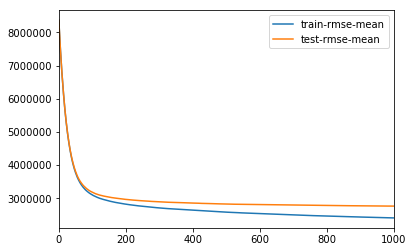

In [27]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

NameError: name 'id_test' is not defined

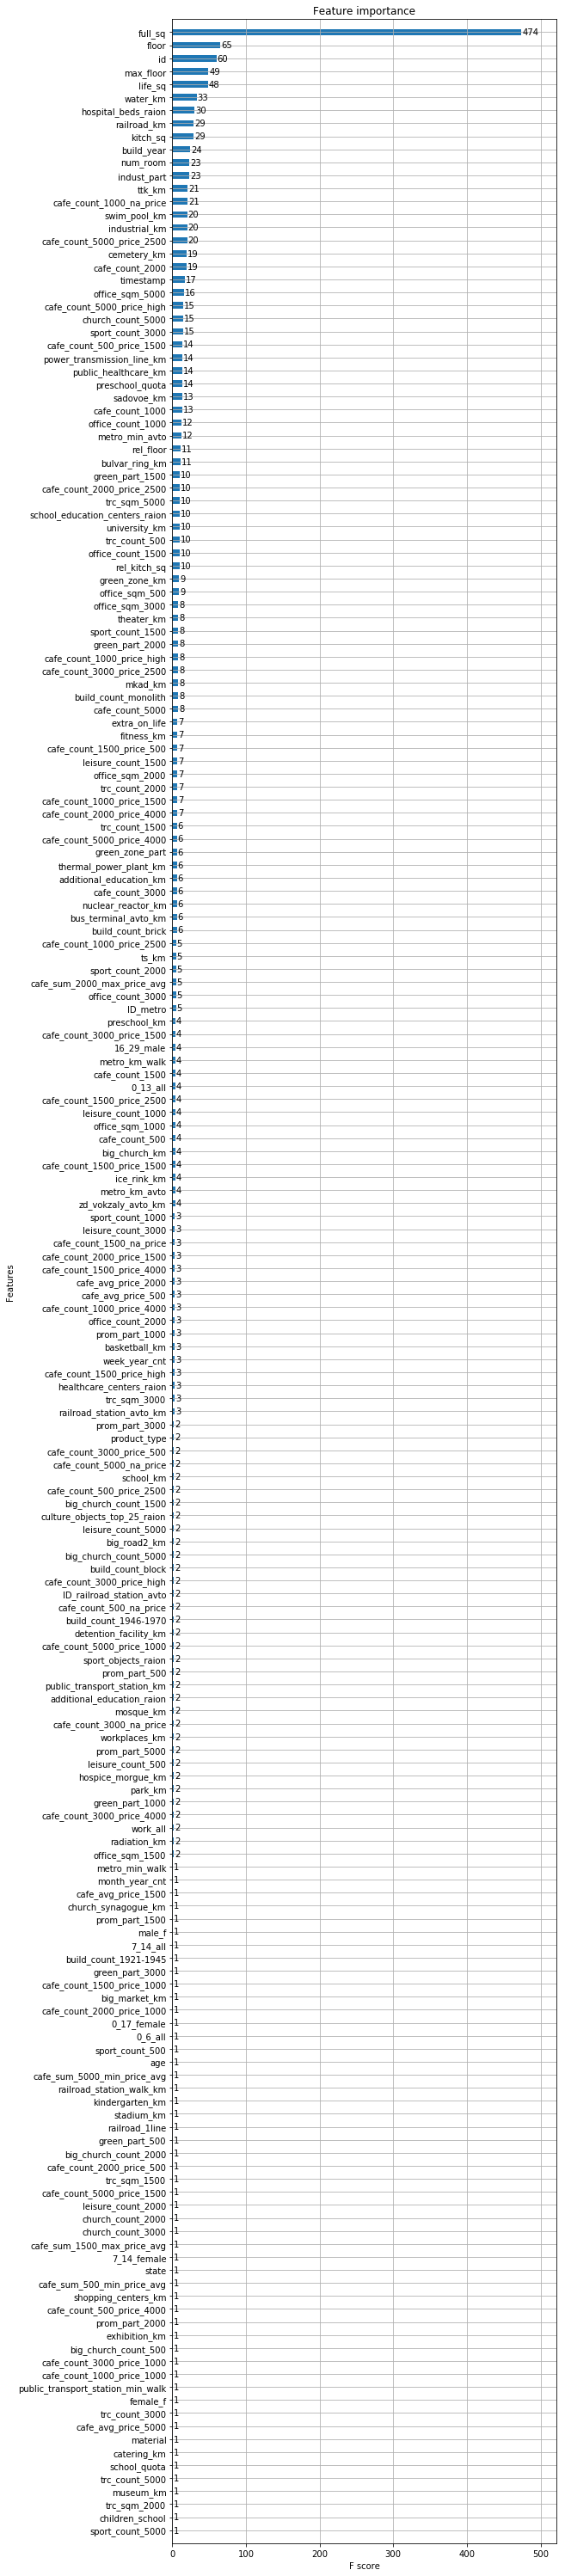

In [28]:
num_boost_rounds = 600

# Tune XGB `num_boost_rounds`

# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)


# Save the csv
# df_sub.to_csv('sub_param_tuned_3_pradeep.csv', index=False)

In [29]:
y_pred

array([ 6195489.,  8367187.,  5835043., ...,  5593651.,  5634272.,
        8596180.], dtype=float32)

### Split into two regions (by price)

In [30]:
split_value = 11000000 # determined by normality 

In [31]:
df_train_high = df_train.loc[df_train['price_doc'] > split_value, :]
df_test_high = df_test.loc[df_train['price_doc'] > split_value, :]

In [32]:
y_train_high = df_train_high['price_doc']

In [33]:
df_train_low = df_train.loc[df_train['price_doc'] < split_value, :]
df_test_low = df_test.loc[df_train['price_doc'] < split_value, :]

In [34]:
y_train_low = df_train_low['price_doc']

Train a model for high-priced responses (log_price) and low-priced responses (price)

### High Prices (5%)

In [35]:
y_train_high = df_train_high.loc[df_train_high['price_doc'].notnull(), 'price_doc']
X_train_high = df_train_high.loc[df_train_high['price_doc'].notnull(), df_train_high.columns != 'price_doc']
X_test_high = df_test_high.loc[df_test_high['price_doc'].isnull(), df_test_high.columns != 'price_doc']

In [36]:
y_train_high = np.log1p(y_train_high)

In [37]:
# Save the column names for features names
df_columns = X_train_high.columns


# Set the parameters
xgb_params = {
    'eta': 0.03,   # 0.05 orig
    'max_depth': 2,    # 5 orig
    'subsample': 0.7,     # 0.7 orig
    'colsample_bytree': 0.7,     # 0.7 orig
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then make predictions
dtrain = xgb.DMatrix(X_train_high.values, y_train_high.values, feature_names=df_columns)
dtest = xgb.DMatrix(X_test_high.values, feature_names=df_columns)

In [38]:
X_train_high.shape, y_train.shape

((3636, 302), (30471,))

[0]	train-rmse:15.5615	test-rmse:15.5615
[1]	train-rmse:15.0951	test-rmse:15.0951
[2]	train-rmse:14.6428	test-rmse:14.6428
[3]	train-rmse:14.204	test-rmse:14.204
[4]	train-rmse:13.7783	test-rmse:13.7783
[5]	train-rmse:13.3655	test-rmse:13.3655
[6]	train-rmse:12.965	test-rmse:12.965
[7]	train-rmse:12.5765	test-rmse:12.5765
[8]	train-rmse:12.1998	test-rmse:12.1998
[9]	train-rmse:11.8343	test-rmse:11.8343
[10]	train-rmse:11.4798	test-rmse:11.4798
[11]	train-rmse:11.1358	test-rmse:11.1358
[12]	train-rmse:10.8023	test-rmse:10.8022
[13]	train-rmse:10.4786	test-rmse:10.4786
[14]	train-rmse:10.1648	test-rmse:10.1648
[15]	train-rmse:9.8605	test-rmse:9.8605
[16]	train-rmse:9.5652	test-rmse:9.5652
[17]	train-rmse:9.27881	test-rmse:9.27881
[18]	train-rmse:9.00111	test-rmse:9.0011
[19]	train-rmse:8.7316	test-rmse:8.7316
[20]	train-rmse:8.47027	test-rmse:8.47027
[21]	train-rmse:8.21679	test-rmse:8.21679
[22]	train-rmse:7.97078	test-rmse:7.97078
[23]	train-rmse:7.73224	test-rmse:7.73227
[24]	train-rm

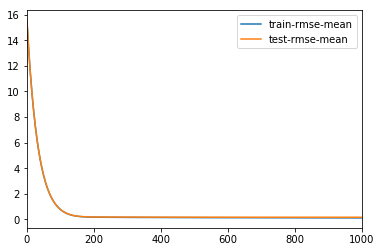

In [39]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

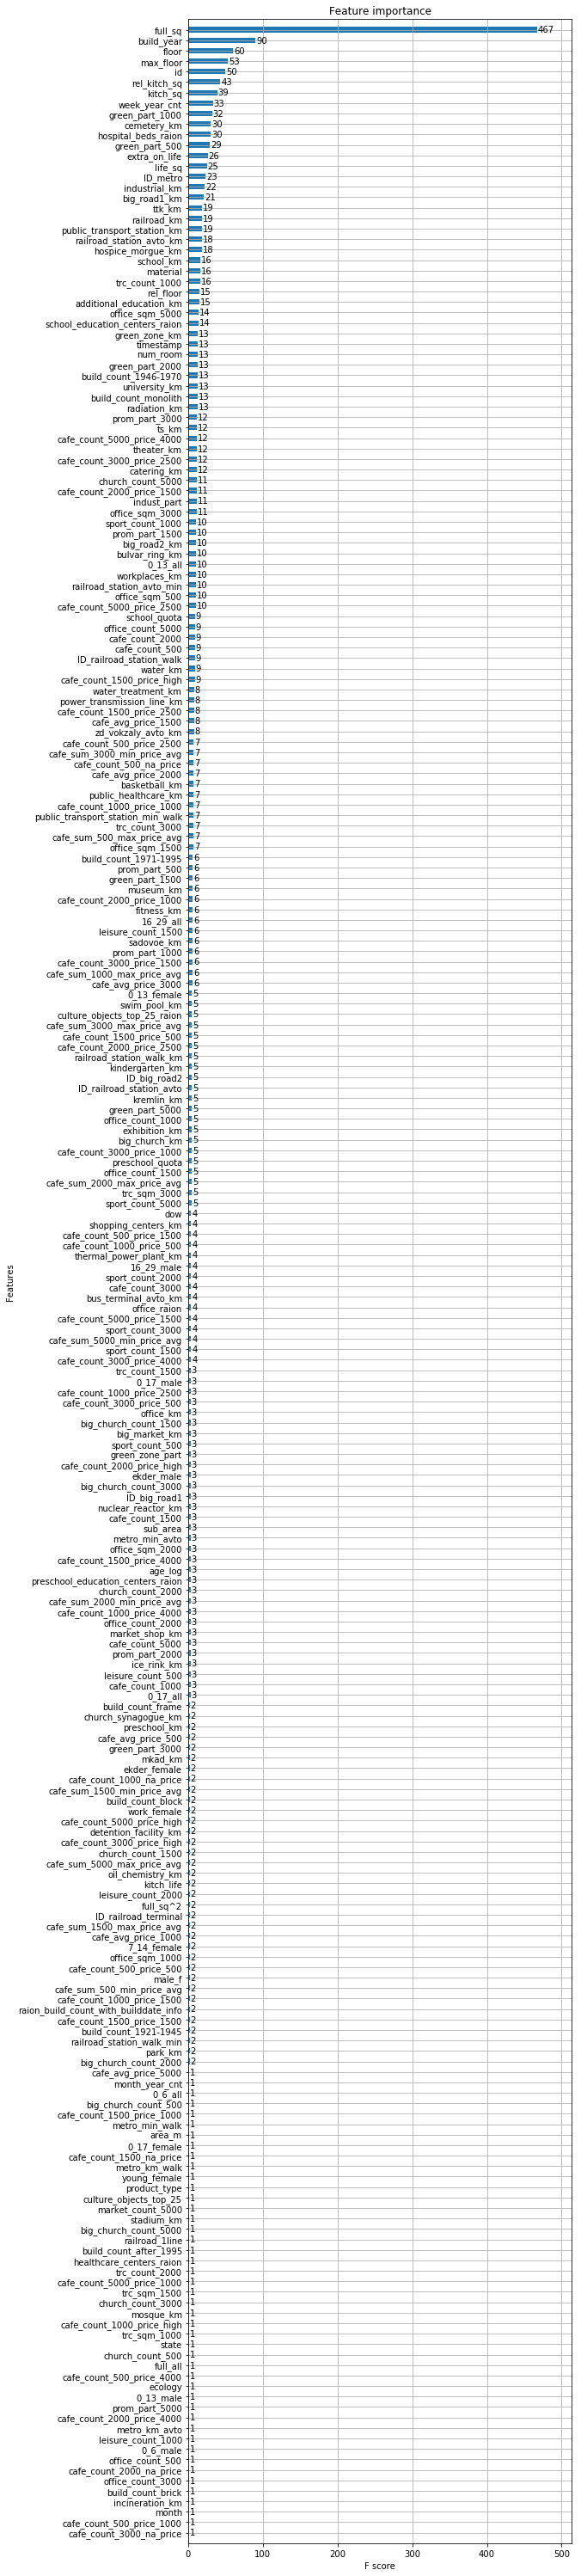

In [40]:
num_boost_rounds = 800

# Tune XGB `num_boost_rounds`

# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)


# Save the csv
# df_sub.to_csv('sub_param_tuned_3_pradeep.csv', index=False)

In [41]:
y_test_high = y_pred

### Low Prices (95%)

In [42]:
y_train_low = df_train_low.loc[df_train_low['price_doc'].notnull(), 'price_doc']
X_train_low = df_train_low.loc[df_train_low['price_doc'].notnull(), df_train_low.columns != 'price_doc']
X_test_low = df_test_low.loc[df_test_low['price_doc'].isnull(), df_test_low.columns != 'price_doc']

In [44]:
# Save the column names for features names
df_columns = X_train_low.columns


# Set the parameters
xgb_params = {
    'eta': 0.03,   # 0.05 orig
    'max_depth': 2,    # 5 orig
    'subsample': 0.7,     # 0.7 orig
    'colsample_bytree': 0.7,     # 0.7 orig
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then make predictions
dtrain = xgb.DMatrix(X_train_low.values, y_train_low.values, feature_names=df_columns)
dtest = xgb.DMatrix(X_test_low.values, feature_names=df_columns)

In [45]:
X_train_low.shape, y_train.shape

((26701, 302), (30471,))

[0]	train-rmse:6.10791e+06	test-rmse:6.10795e+06
[1]	train-rmse:5.94547e+06	test-rmse:5.94565e+06
[2]	train-rmse:5.78798e+06	test-rmse:5.78809e+06
[3]	train-rmse:5.63601e+06	test-rmse:5.6361e+06
[4]	train-rmse:5.48867e+06	test-rmse:5.48884e+06
[5]	train-rmse:5.34685e+06	test-rmse:5.34705e+06
[6]	train-rmse:5.21e+06	test-rmse:5.21028e+06
[7]	train-rmse:5.07799e+06	test-rmse:5.07821e+06
[8]	train-rmse:4.95014e+06	test-rmse:4.9504e+06
[9]	train-rmse:4.82702e+06	test-rmse:4.82744e+06
[10]	train-rmse:4.70848e+06	test-rmse:4.70889e+06
[11]	train-rmse:4.59362e+06	test-rmse:4.59396e+06
[12]	train-rmse:4.48214e+06	test-rmse:4.48266e+06
[13]	train-rmse:4.37542e+06	test-rmse:4.37609e+06
[14]	train-rmse:4.2721e+06	test-rmse:4.27283e+06
[15]	train-rmse:4.17191e+06	test-rmse:4.17278e+06
[16]	train-rmse:4.07605e+06	test-rmse:4.0769e+06
[17]	train-rmse:3.98341e+06	test-rmse:3.98441e+06
[18]	train-rmse:3.89452e+06	test-rmse:3.89555e+06
[19]	train-rmse:3.80826e+06	test-rmse:3.80924e+06
[20]	train-rmse:3

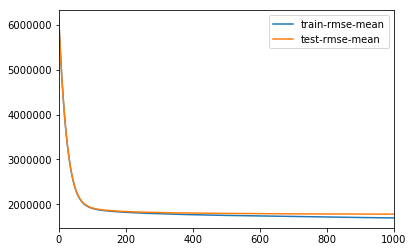

In [46]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

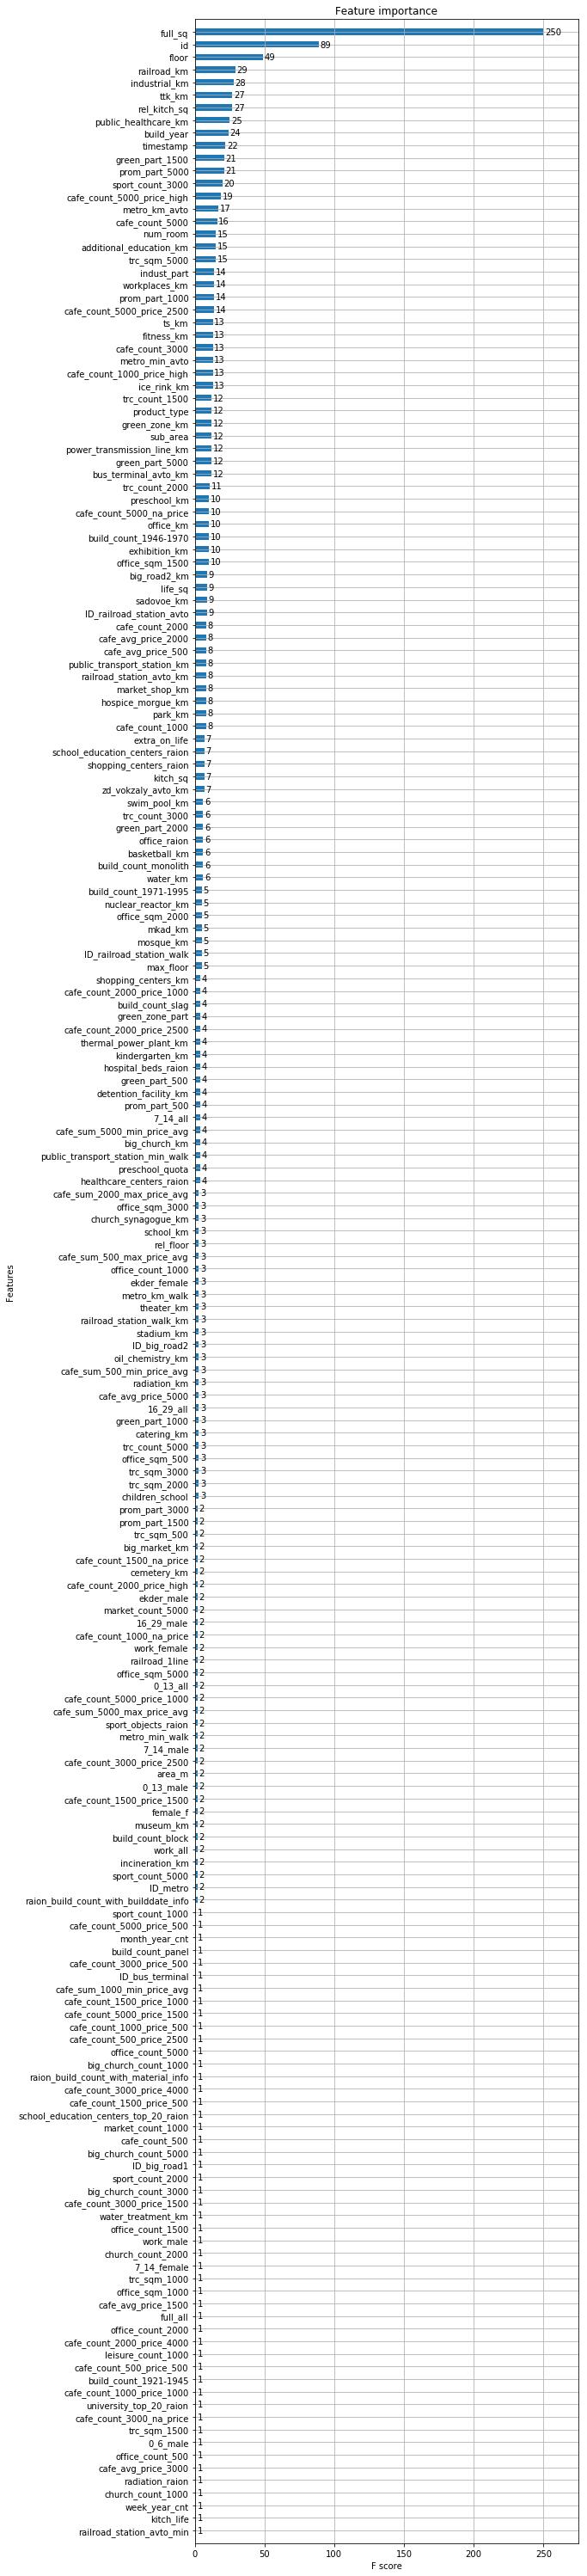

In [47]:
num_boost_rounds = 500

# Tune XGB `num_boost_rounds`

# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)


# Save the csv
# df_sub.to_csv('sub_param_tuned_3_pradeep.csv', index=False)

In [48]:
y_test_low = y_pred

### Add to low/high datasets

### Merge and submit

In [49]:
len(y_test_high), len(y_test_low),  len(y_test_high) + len(y_test_low)

(659, 6969, 7628)

In [50]:
len(X_test_high), len(X_test_low),  len(X_test_high) + len(X_test_low)

(659, 6969, 7628)

In [51]:
X_test_high['price_doc'] = np.expm1(y_test_high)
X_test_low['price_doc'] = y_test_low

In [52]:
frames = [X_test_low, X_test_high]

X_test = pd.concat(frames)

In [53]:
frames = [X_train_low, X_train_high]

X_train = pd.concat(frames)

In [54]:
frames = [y_train_low, y_train_high]

y_train = pd.concat(frames)

In [55]:
y_pred = X_test[['id','price_doc']]

In [56]:
sample = pd.read_csv('../EDA/submissions/31310.csv')

In [57]:
sample = sample.merge(y_pred, left_on='id',right_on='id',how='left')

In [58]:
sample.loc[sample['price_doc_y'].isnull(), 'price_doc_y'] = sample.loc[sample['price_doc_y'].isnull(), 'price_doc_x']

In [256]:
# sample['price_doc'] = (sample['price_doc_x'] + sample['price_doc_y'])/2

In [60]:
sample

,id,price_doc_x,price_doc_y
0,30474,5434544.0,5624246.50
1,30475,8202008.0,8142149.00
2,30476,5621595.0,5871584.00
3,30477,5791226.0,11773665.00
4,30478,4799440.0,9828750.00
5,30479,9380446.0,8102527.50
6,30480,4157150.0,4726336.00
7,30481,4074462.0,4651758.50
8,30482,4784814.0,4859559.00
9,30483,4695106.0,4626447.00


In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline 



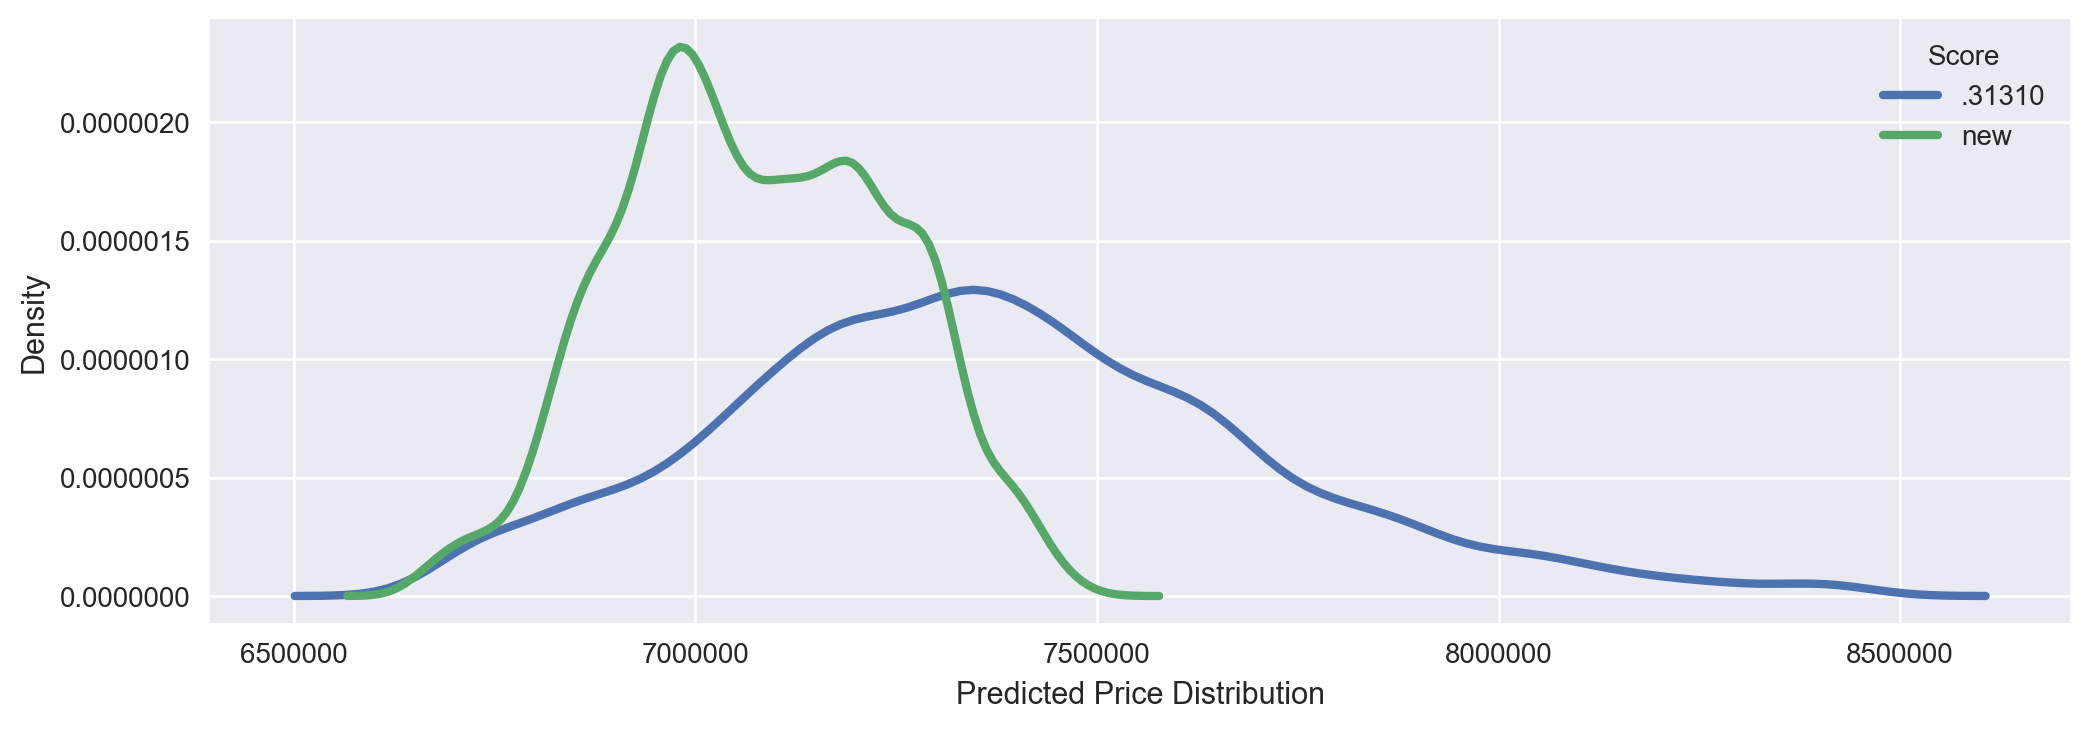

In [63]:
plt.figure(figsize=(12,4),dpi=200)
sns.kdeplot(sample['price_doc_x'].rolling(window=300).mean(), label='.31310',lw=3)
sns.kdeplot(sample['price_doc_y'].rolling(window=300).mean(), label='new',lw=3)
# sns.kdeplot(sample['price_doc'].rolling(window=300).mean(), label='mean',lw=3)
plt.xlabel('Predicted Price Distribution')
plt.ylabel('Density')
plt.legend(title='Score')
plt.show()

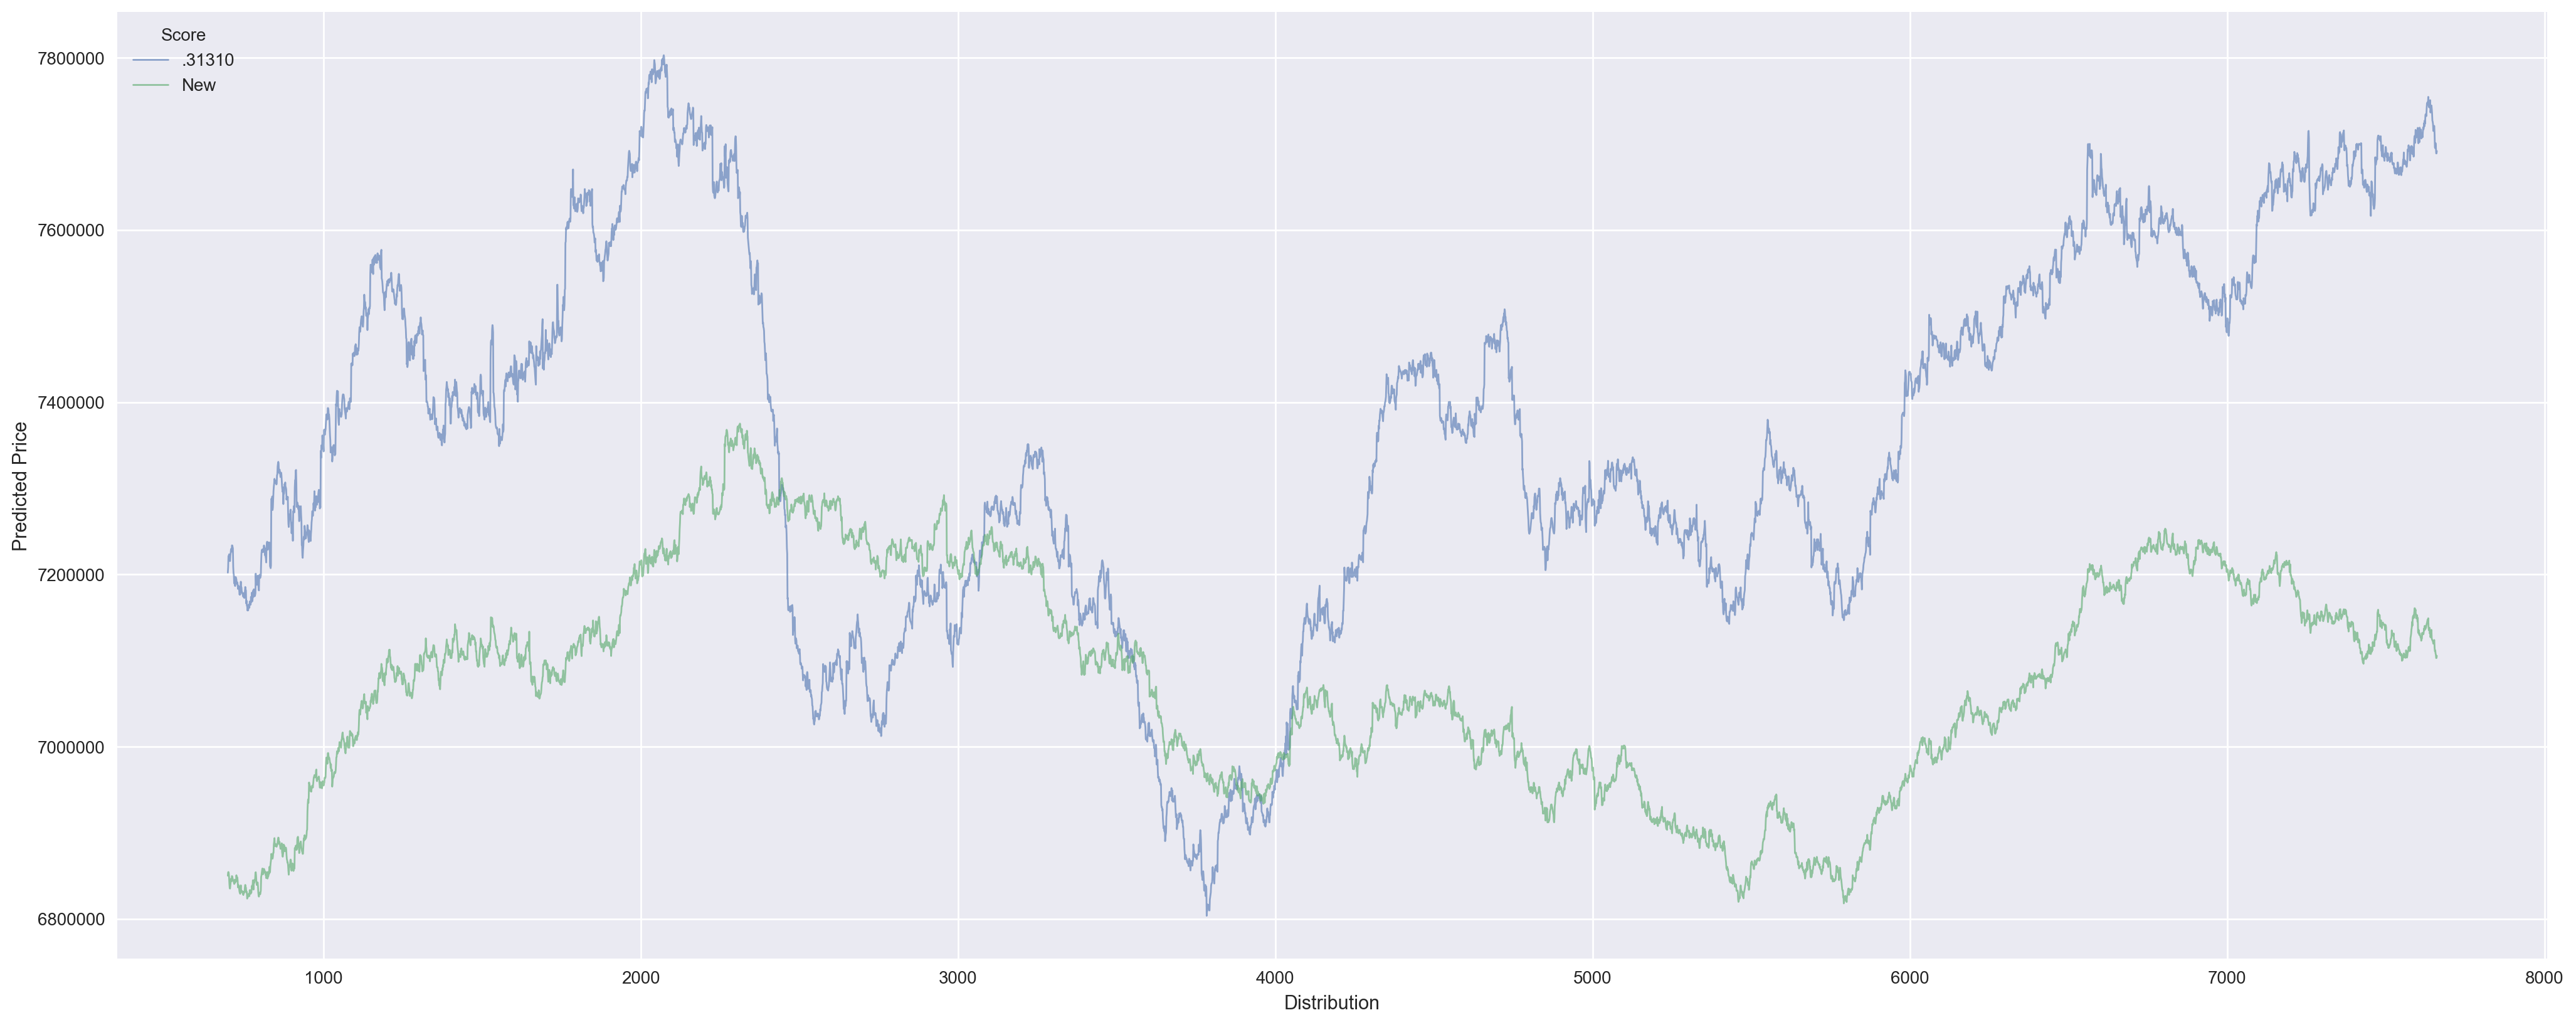

In [65]:
plt.figure(figsize=(25,10),dpi=200)
plt.plot(sample['price_doc_x'].rolling(window=700).mean(), label='.31310', alpha =0.6, lw=1)
plt.plot(sample['price_doc_y'].rolling(window=700).mean(), label='New', alpha =0.6, lw=1)
# plt.plot(sample['price_doc'].rolling(window=700).mean(), label='Mean', alpha =1, lw=2)
plt.xlabel('Distribution')
plt.ylabel('Predicted Price')
plt.legend(title='Score')
plt.show()

In [66]:
submission = sample[['id', 'price_doc']]
submission.set_index('id')

KeyError: "['price_doc'] not in index"

In [308]:
submission['price_doc'] = submission['price_doc']*.97

In [309]:
submission.to_csv('../EDA/submissions/submission_053117.csv')

In [304]:
submission = submission.set_index('id')

In [293]:
submit = pd.read_csv('../EDA/submissions/weighted_final_053017.csv', index_col='id')

In [310]:
submission

,price_doc
id,
30474,5.288503e+06
30475,7.922946e+06
30476,5.280664e+06
30477,9.653219e+06
30478,8.424929e+06
30479,8.389365e+06
30480,4.249527e+06
30481,4.344876e+06
30482,4.732974e+06


In [294]:
submit['price_doc'] = sample['price_doc']

In [306]:
submission.to_csv('../EDA/submissions/submission_053117.csv', index=True)